<a href="https://colab.research.google.com/github/giuliovv/ball_beam/blob/master/nmpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
colab = False

if colab:
  %pip install casadi

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

In [31]:
# Hyperparameters
test_results = True
N = 10 # Number of control intervals
Q, Q1, Q2, Q3, R = 1e3, 0, 0, 0, 1 # Error, thetadot, theta, xdot, u

Ts = 0.3 #T/N

Initialize states, inputs, and system dynamic equation

In [32]:
# States
x1 = MX.sym('x1') #thetadot
x2 = MX.sym('x2') #theta
x3 = MX.sym('x3') #xdot
x4 = MX.sym('x4') #x
x = vertcat(x1,x2,x3,x4) # Always vertically concatenate the states --> [n_x,1]
# Inputs
u1 = MX.sym('u')
u = vertcat(u1) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
f1 = -34.68*x1 + 59.33*u
f2 = x1
f3 = 0.26*x2
f4 = x3

ode = vertcat(f1,f2,f3,f4) # ORDINARY DIFFERENTIAL EQUATION: Always vertically concatenate dynamic equations --> [n_x,1]
f = Function('f_o',[x,u],[ode],['x','u'],['ode'])
if test_results:
    print(f([0,0,0.2,0.8], 0.1))

[5.933, 0, 0, 0.2]


Define the integrator to discretize the system

In [33]:
# Integrator to discretize the ordinary differential equation --> differential algebraic equation
intg_options = dict()
intg_options['tf'] = Ts
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 4
# DAE problem structure
dae = dict()
dae['x'] = x    # Variables 
dae['p'] = u    # Parameters (N.B. for an MPC, the inputs are passed to DAE as parameters)
dae['ode'] = f(x,u) # Expression in continuos time

intg = integrator('intg','rk', dae, intg_options) # Runge-Kutta

if test_results: # To numerically evaluate the DAE
    res = intg(x0=[0,0,0,1],p=0)
    print(res['xf'])

# For the system dynamics, we need the symbolic DAE to update system state
res = intg(x0=x, p=u) 
x_next = res['xf'] # Access x_next as the DAE symbolic solution

# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = Function('F',[x,u],[x_next],['x','u'],['x_next'])

[0, 0, 0, 1]


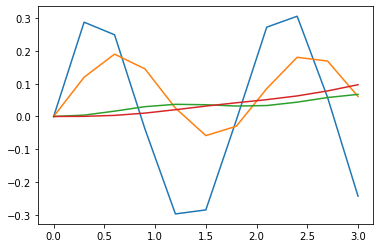

In [34]:
# Test the problem definition
sim = F.mapaccum(N) # To call the F function N times
x0 = [0,0,0,0]
res = sim(x0, np.cos(np.arange(N))/4) # Example: u1 = cosine excitation
fig = plt.figure()
tgrid = np.linspace(0,Ts*N,N+1)
plt.plot(tgrid, np.column_stack((x0, res)).T)

-------------------------------------------
This is casadi::QRQP
Number of variables:                              54
Number of constraints:                            86
Number of nonzeros in H:                          21
Number of nonzeros in A:                         226
Number of nonzeros in KKT:                       592
Number of nonzeros in QR(V):                     552
Number of nonzeros in QR(R):                    1113
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1     4e+02     3   0.00026    61         0  
    1     0    -3e+02      0.68   115   7.1e-11     7   0.00014    61         1  Added ubz to reduce |pr|, i=115
    2     0  -2.9e+02      0.42   116   3.8e-11     7   8.8e-05    61         1  Added ubz to reduce |pr|, i=116
    3     0  -2.9e+02   1.8e-14    65   5.8e-12    19   8.8e-05    61         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations


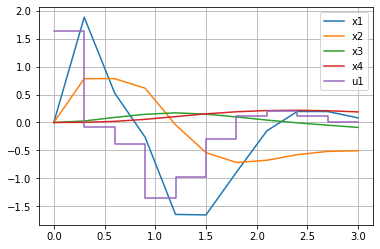

In [35]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(4,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(1,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(4,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(1)
c = opti.parameter(1)       # Test in simulink if optimizer runs online

obj = Q*sumsqr(x[-1,:] - r) + Q1*sumsqr(x[0,:]) + Q2*sumsqr(x[1,:]) + Q3*sumsqr(x[2,:]) + R*sumsqr(u)# + 1e6*sumsqr(x[1,-1] - r)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(u<=6)        
opti.subject_to(u>=-6)
opti.subject_to(x[1,:]<=pi/4)        
opti.subject_to(x[1,:]>=-pi/4)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[0, 0, 0, 0]) # Set the initial x0 value
opti.set_value(r,0.2)
opti.set_value(c,1)

opts = dict()
opts["qpsol"] = "qrqp" # qrqp or osqp
opts["print_header"] = False
opts["print_iteration"] = False
opts["print_time"] = False
#opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False})
opti.solver("sqpmethod", opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve() # For testing purpose: test the optimization on 1 time step
    fig = plt.figure
    plt.plot(tgrid, sol.value(x[0,:]).T, label='x1')
    plt.plot(tgrid, sol.value(x[1,:]).T, label='x2')
    plt.plot(tgrid, sol.value(x[2,:]).T, label='x3')
    plt.plot(tgrid, sol.value(x[3,:]).T, label='x4')
    plt.plot(tgrid, np.column_stack((sol.value(u).reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='u1')
    plt.grid(True)
    plt.legend()

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [36]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('f',[p, r, c],[u[:,0], c],['p', 'r', 'c'],['u_opt', 'c'])

-------------------------------------------
This is casadi::QRQP
Number of variables:                              54
Number of constraints:                            86
Number of nonzeros in H:                          21
Number of nonzeros in A:                         226
Number of nonzeros in KKT:                       592
Number of nonzeros in QR(V):                     552
Number of nonzeros in QR(R):                    1113


In [37]:
# Reference point
r = 0.2

# Simulink test
c = 1

# MPC loop
X_log = np.empty((4,0))
U_log = np.array([])

x = [0,0,0,0]
for i in range(20):
    u, c = M(x, r, c)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u)# + [0,0,0, np.random.rand()*0.002]

 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1     4e+02     3   0.00026    61         0  
    1     0    -3e+02      0.68   115   7.1e-11     7   0.00014    61         1  Added ubz to reduce |pr|, i=115
    2     0  -2.9e+02      0.42   116   3.8e-11     7   8.8e-05    61         1  Added ubz to reduce |pr|, i=116
    3     0  -2.9e+02   1.8e-14    65   5.8e-12    19   8.8e-05    61         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0       1.9   136     4e+02     3   0.00026    61         0  
    1     0  -3.4e+02      0.42   115   4.2e-11    11   0.00014    61         1  Added ubz to reduce |pr|, i=115
    2     0  -3.3e+02   3.2e-14    65   1.3e-11     7   0.00014    61         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk  

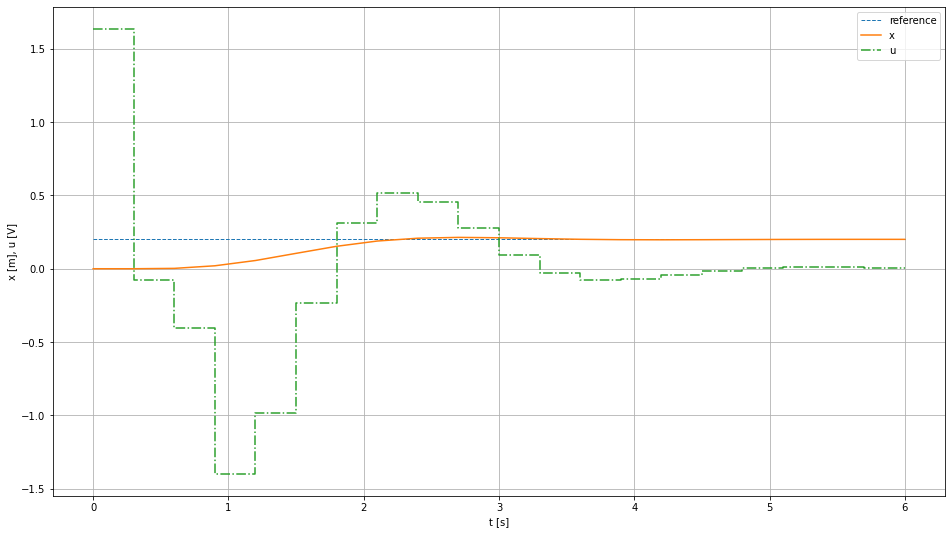

In [38]:
# Plot results!
fig = plt.figure(figsize=(16,9))
plt.plot((0, 6), (r, r), '--',linewidth=1, label="reference")
tgrid_mpc = np.linspace(0,Ts*20,20+1)
#plt.plot(tgrid_mpc, np.append(x0[0], X_log[0,:]).T, label ='x1')
#plt.plot(tgrid_mpc, np.append(x0[1], X_log[1,:]).T, label ='x2')
#plt.plot(tgrid_mpc, np.append(x0[2], X_log[2,:]).T, label ='x3')
plt.plot(tgrid_mpc, np.append(x0[3], X_log[3,:]).T, label ='x')
plt.plot(tgrid_mpc, np.append(U_log, np.NaN).T, linestyle='-.', drawstyle='steps-post', label="u")
plt.xlabel('t [s]')
plt.ylabel('x [m], u [V]')
plt.grid(True)
plt.legend()

In [39]:
f"Max sovraelongazione: {X_log[3,:].max()-r}"

'Max sovraelongazione: 0.01378130005716377'

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [40]:
M.save('M.casadi')
f = M

In [41]:
# Use this to build an S-Function

opts = dict(mex=True)
cg_options = dict()
cg_options["casadi_real"] = 'real_T'
cg_options["casadi_int"] = 'int_T'
cg_options["with_header"] = True
#cg_options["mex"] = True
cg = CodeGenerator('f',cg_options)
cg.add_include('simstruc.h');
cg.add(f);
cg.generate();

In [42]:
# Use this to build a simple MEX

#opts = dict(mex=True, with_header=True, casadi_real='real_T', casadi_int="int_T")
#f.generate('f.c',opts)